# Maneuver Classification with rolling windows and LSTM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.metrics import confusion_matrix
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from numpy.random import default_rng
import math

2023-06-27 21:26:58.654073: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv("data/SensorRec_data_eng.csv")
df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
0,2023-01-06 10:44:29.466,0.021387,-0.006456,-0.084595,-0.072036,-0.009720,-0.006924,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
2,2023-01-06 10:44:30.456,0.030368,-0.006946,0.019102,0.000000,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
4,2023-01-06 10:44:31.456,0.017861,0.001417,0.017249,-0.001332,-0.002397,0.000399,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01


# Data cleaning & preparation:

In [3]:
unique_maneuvers = df.drop_duplicates(subset=['maneuverID','maneuverType'])['maneuverType'].value_counts()

fig = px.bar(x=unique_maneuvers.index, y=unique_maneuvers.values,
            title='Amount of maneuvers per type')

fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount of entries')
fig.show()

Dropping maneuvers with less than 30 cases:


In [4]:
df = df.drop(df[(df.maneuverType == 'acceleration_lane') | (df.maneuverType == 'overtaking') |
                         (df.maneuverType == 'deceleration_lane') | (df.maneuverType == 'crossing_roundabout') |
                         (df.maneuverType == 'crossing_intersection')].index)

# drop every 2nd row of 'Fahren_kontinuierlich' and 'Stand'ArithmeticError

index_fahren = df[df['maneuverType'] == 'Fahren_kontinuierlich'].index[::2]
index_stand = df[df['maneuverType'] == 'Stand'].index[::2]

df = df.drop(index_fahren)
df = df.drop(index_stand)

df.maneuverType.unique()

array(['stationary', 'curve_right', 'curve_left', 'continuous_driving',
       'turn_left', 'turn_right', 'targeted_braking',
       'acceleration_from_standing'], dtype=object)

In [5]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

def sliced_train_test(df, X_vars, y_var, splits, test_size, time_steps, stepsize):
    split_list = np.array_split(df, splits)
    
    rng = default_rng()
    numbers = rng.choice(splits, size=math.floor(splits*test_size), replace=False)

    df_full = df.copy()

    # remove test slices from dataframe
    for num in numbers:
        df = df.drop(split_list[num].index)

    # Scale based on training data
    scaler = RobustScaler()
    scaler = scaler.fit(df[X_vars])
    df.loc[:, X_vars] = scaler.transform(df[X_vars].to_numpy())

    # sample test splits based on random numbers
    X_test, y_test = [], []
    for num in numbers:
        split_idx = split_list[num].index
        
        extract = df_full.loc[split_idx,:]
        extract.loc[:, X_vars] = scaler.transform(extract[X_vars].to_numpy())
        
        X_slice, y_slice = create_dataset(extract[X_vars], extract[y_var], time_steps, stepsize)

        X_test.append(X_slice)
        y_test.append(y_slice)
    
    X_test, y_test = np.vstack(X_test), np.vstack(y_test)
    #y_test = np.vstack(y_test)

    X_train, y_train = create_dataset(df[X_vars], df[y_var], time_steps, stepsize)
    
    return X_train, y_train, X_test, y_test

In [6]:
df_p1 = df.loc[df['person']=='P01',:]
df_p2 = df.loc[df['person']=='P02',:]
df_p3 = df.loc[df['person']=='P03',:]

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed']
y_var = 'maneuverType'
splits = 10
test_size = 0.2
time_steps = 20
stepsize = 1

X_train1, y_train1, X_test1, y_test1 = sliced_train_test(df_p1, x_vars, y_var, splits, test_size,
                                                         time_steps, stepsize)

X_train2, y_train2, X_test2, y_test2 = sliced_train_test(df_p2, x_vars, y_var, splits, test_size,
                                                         time_steps, stepsize)

X_train3, y_train3, X_test3, y_test3 = sliced_train_test(df_p3, x_vars, y_var, splits, test_size,
                                                         time_steps, stepsize)

X_train = np.vstack((X_train1, X_train2, X_train3))
y_train = np.vstack((y_train1, y_train2, y_train3))
X_test = np.vstack((X_test1, X_test2, X_test3))
y_test = np.vstack((y_test1, y_test2, y_test3))

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

/opt/anaconda3/envs/p3-8-tensorflow04-telematic/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RobustScaler was fitted with feature names

/opt/anaconda3/envs/p3-8-tensorflow04-telematic/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RobustScaler was fitted with feature names

/var/folders/_1/6fqc4jrn1n78r_dr5zwl5ctc0000gn/T/ipykernel_2406/4152217424.py:7: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/var/folders/_1/6fqc4jrn1n78r_dr5zwl5ctc0000gn/T/ipykernel_2406/4152217424.py:7: DeprecationWarning:

Support for

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((22102, 20, 7), (22102, 8), (5422, 20, 7), (5422, 8))

In [8]:
def lstm_model(X_train, y_train, epochs, batch_size, optimizer):
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=32,
            input_shape=[X_train.shape[1], X_train.shape[2]]
        )
        )
    )
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['acc']
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        shuffle=True
    )
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend();

    return model

Epoch 1/30
78/78 [==============================] - 5s 22ms/step - loss: 1.3961 - acc: 0.5913 - val_loss: 0.3421 - val_acc: 0.8964
Epoch 2/30
78/78 [==============================] - 1s 13ms/step - loss: 0.6914 - acc: 0.7625 - val_loss: 0.2438 - val_acc: 0.9077
Epoch 3/30
78/78 [==============================] - 1s 17ms/step - loss: 0.5390 - acc: 0.8188 - val_loss: 0.1849 - val_acc: 0.9285
Epoch 4/30
78/78 [==============================] - 1s 16ms/step - loss: 0.4519 - acc: 0.8504 - val_loss: 0.1603 - val_acc: 0.9471
Epoch 5/30
78/78 [==============================] - 1s 13ms/step - loss: 0.3930 - acc: 0.8731 - val_loss: 0.1702 - val_acc: 0.9417
Epoch 6/30
78/78 [==============================] - 1s 14ms/step - loss: 0.3577 - acc: 0.8855 - val_loss: 0.1491 - val_acc: 0.9516
Epoch 7/30
78/78 [==============================] - 1s 14ms/step - loss: 0.3364 - acc: 0.8925 - val_loss: 0.1713 - val_acc: 0.9439
Epoch 8/30
78/78 [==============================] - 1s 15ms/step - loss: 0.3177 - a

[0.6394098401069641, 0.8637034296989441]

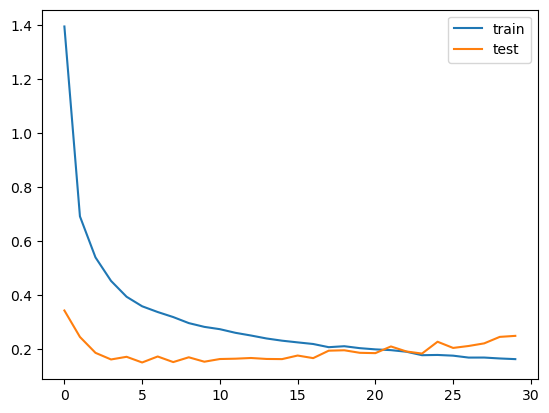

In [11]:
model = lstm_model(X_train, y_train, epochs=30, batch_size=256, optimizer='adam')
model.evaluate(X_test, y_test)

In [13]:
cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
heatmap = go.Heatmap(z=cm, x=enc.categories_[0], y=enc.categories_[0], colorscale='Blues') # FEHLER IRGENDWO

# create the layout
layout = go.Layout(title='Confusion Matrix')

# create the figure
fig = go.Figure(data=[heatmap], layout=layout)

fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
fig.update_yaxes(title_text="Actual")
fig.update_xaxes(title_text="Predicted")

fig.layout.height = 900
fig.layout.width = 900
# show the figure
fig.show()

In [12]:
def relativeCorrect(array):
    return array/sum(array)

def confusion_matrix_relative(y_test, y_pred):

    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    cm_relative = np.apply_along_axis(relativeCorrect, 1, cm)
    heatmap = go.Heatmap(z=cm_relative, x=enc.categories_[0], y=enc.categories_[0],
                         colorscale='Blues')


    # create the layout
    layout = go.Layout(title='Confusion Matrix with relative values for each row / actual classes')

    # create the figure
    fig = go.Figure(data=[heatmap], layout=layout)

    fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
    fig.update_yaxes(title_text="Actual")
    fig.update_xaxes(title_text="Predicted")

    fig.layout.height = 900
    fig.layout.width = 900
    # show the figure
    fig.show()

y_pred = model.predict(X_test)

confusion_matrix_relative(y_test, y_pred)

170/170 [==============================] - 1s 3ms/step


Archiv:

In [5]:
df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
0,2023-01-06 10:44:29.466,0.021387,-0.006456,-0.084595,-0.072036,-0.009720,-0.006924,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
2,2023-01-06 10:44:30.456,0.030368,-0.006946,0.019102,0.000000,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
4,2023-01-06 10:44:31.456,0.017861,0.001417,0.017249,-0.001332,-0.002397,0.000399,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01


In [3]:
fig = px.bar(x=df.maneuverType.value_counts().index, y=df.maneuverType.value_counts().values,
            title='Amount of entries per maneuver type')

fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount of entries')
fig.show()

def type_to_elements(df, maneuverType, roadTypes, elements):
    
    for road in roadTypes:
        for element in elements:
            df.loc[(df['maneuverType']== maneuverType) & (df['roadType']== road) & (df['maneuverElement']== element),
                'maneuverType'] = f"{element}_{road}"
    
    return df

maneuverType = 'Fahren_kontinuierlich'
roadTypes = ['Autobahn', 'Landstraße', 'Stadtstraße', 'Bundesstraße']
elements = ['Verlangsamen', 'Beschleunigen']

df = type_to_elements(df, maneuverType, roadTypes, elements)
df.shape

In [91]:
# drop every 2nd row of 'Fahren_kontinuierlich' and 'Stand'ArithmeticError

index_fahren = df[df['maneuverType'] == 'Fahren_kontinuierlich'].index[::2]
index_stand = df[df['maneuverType'] == 'Stand'].index[::2]

df = df.drop(index_fahren)
df = df.drop(index_stand)

df = df.drop(df[(df.maneuverType == 'Auffahrt_Beschleunigungsstreifen') | (df.maneuverType == 'Überholen') |
                         (df.maneuverType == 'Durchfahren_Kreisverkehr') | (df.maneuverType == 'Durchfahren_ampelloser_Kreuzungen') |
                         (df.maneuverType == 'Spurwechsel_links') | (df.maneuverType == 'Spurwechsel_rechts') |
                         (df.maneuverType == 'Abfahrt_Verzögerungsstreifen')].index)

df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
5,2023-01-06 10:44:31.958,0.006959,0.002400,0.022964,-0.000932,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
7,2023-01-06 10:44:32.958,0.021171,0.007422,0.040046,-0.000666,-0.002929,-0.000133,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
9,2023-01-06 10:44:33.958,-0.015010,-0.004745,-0.051769,-0.000266,-0.000133,0.000266,52.366270,9.761421,98.700005,6.913,0.006310,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01


In [92]:
fig = px.bar(x=df.maneuverType.value_counts().index, y=df.maneuverType.value_counts().values,
            title='Amount of entries per maneuver type')

fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount of entries')
fig.show()

In [93]:

scale_columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed']

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(
  df[scale_columns].to_numpy()
)

df.head()

/opt/anaconda3/envs/p3-8-tensorflow04-telematic/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RobustScaler was fitted with feature names



,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
1,2023-01-06 10:44:29.958,0.186451,0.829335,0.795743,0.851852,0.308333,0.055556,52.366269,9.761421,98.700005,11.716,-0.791473,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.099932,-0.048232,-0.019720,-0.046296,0.083333,0.125000,52.366270,9.761421,98.700005,9.591,-0.793391,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
5,2023-01-06 10:44:31.958,0.058595,0.018774,0.096430,-0.129630,-0.116667,0.138889,52.366270,9.761421,98.700005,9.591,-0.793391,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
7,2023-01-06 10:44:32.958,0.169993,0.060453,0.195312,-0.111111,-0.175000,0.000000,52.366270,9.761421,98.700005,9.591,-0.793391,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01
9,2023-01-06 10:44:33.958,-0.113599,-0.040523,-0.336174,-0.083333,0.000000,0.041667,52.366270,9.761421,98.700005,6.913,-0.795642,000000-P1M,Stand,Stand,1,Stadtstraße,Skoda Fabia,P01


## Train / Test split

In [97]:
df_p1 = df.loc[df['person']=='P01',:]
df_p2 = df.loc[df['person']=='P02',:]
df_p3 = df.loc[df['person']=='P03',:]

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed']
y_var = 'maneuverType'
splits = 10
test_size = 0.2
time_steps = 20
step = 1

X_train1, y_train1, X_test1, y_test1 = sliced_train_test(df_p1, x_vars, y_var, splits, test_size,
                                                         time_steps, step)

X_train2, y_train2, X_test2, y_test2 = sliced_train_test(df_p2, x_vars, y_var, splits, test_size,
                                                         time_steps, step)

X_train3, y_train3, X_test3, y_test3 = sliced_train_test(df_p3, x_vars, y_var, splits, test_size,
                                                         time_steps, step)

X_train = np.vstack((X_train1, X_train2, X_train3))
y_train = np.vstack((y_train1, y_train2, y_train3))
X_test = np.vstack((X_test1, X_test2, X_test3))
y_test = np.vstack((y_test1, y_test2, y_test3))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

/var/folders/_1/6fqc4jrn1n78r_dr5zwl5ctc0000gn/T/ipykernel_1230/20815925.py:10: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.

/var/folders/_1/6fqc4jrn1n78r_dr5zwl5ctc0000gn/T/ipykernel_1230/20815925.py:10: DeprecationWarning:

Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.

/var/folders/_1/6fqc4jrn1n78r_dr5zwl5ctc0000gn/T/ipykernel_1230/20815925.py:10: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `m

((13551, 20, 7), (13551, 1), (3282, 20, 7), (3282, 1))

In [98]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13551, 20, 7), (13551, 1), (3282, 20, 7), (3282, 1))

In [99]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

/opt/anaconda3/envs/p3-8-tensorflow04-telematic/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [100]:
def lstm_model(X_train, y_train, epochs, batch_size, optimizer):
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=32,
            input_shape=[X_train.shape[1], X_train.shape[2]]
        )
        )
    )
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['acc']
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        shuffle=True
    )
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend();

    return model

model = lstm_model(X_train, y_train, epochs=30, batch_size=256, optimizer='adam')
model.evaluate(X_test, y_test)

Epoch 1/30
48/48 [==============================] - 5s 26ms/step - loss: 1.8926 - acc: 0.3320 - val_loss: 1.0316 - val_acc: 0.6239
Epoch 2/30
48/48 [==============================] - 1s 12ms/step - loss: 1.1996 - acc: 0.5681 - val_loss: 0.5730 - val_acc: 0.8282
Epoch 3/30
48/48 [==============================] - 1s 12ms/step - loss: 0.9219 - acc: 0.6767 - val_loss: 0.3878 - val_acc: 0.8695
Epoch 4/30
48/48 [==============================] - 1s 12ms/step - loss: 0.7534 - acc: 0.7469 - val_loss: 0.3475 - val_acc: 0.8768
Epoch 5/30
48/48 [==============================] - 1s 13ms/step - loss: 0.6746 - acc: 0.7713 - val_loss: 0.3309 - val_acc: 0.8739
Epoch 6/30
48/48 [==============================] - 1s 14ms/step - loss: 0.6221 - acc: 0.7911 - val_loss: 0.3209 - val_acc: 0.8835
Epoch 7/30
48/48 [==============================] - 1s 13ms/step - loss: 0.5774 - acc: 0.8044 - val_loss: 0.3101 - val_acc: 0.8916
Epoch 8/30
48/48 [==============================] - 1s 12ms/step - loss: 0.5518 - a

[0.47799962759017944, 0.8650213479995728]

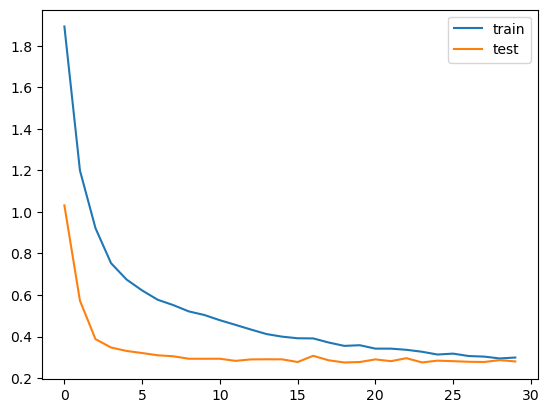

In [101]:
model = lstm_model(X_train, y_train, epochs=30, batch_size=256, optimizer='adam')
model.evaluate(X_test, y_test)


In [102]:
y_pred = model.predict(X_test)

confusion_matrix_relative(y_test, y_pred)

103/103 [==============================] - 1s 2ms/step


Epoch 1/500
48/48 [==============================] - 5s 26ms/step - loss: 2.0472 - acc: 0.2544 - val_loss: 1.9545 - val_acc: 0.5693
Epoch 2/500
48/48 [==============================] - 1s 13ms/step - loss: 1.9717 - acc: 0.3806 - val_loss: 1.8421 - val_acc: 0.5693
Epoch 3/500
48/48 [==============================] - 1s 12ms/step - loss: 1.9126 - acc: 0.3934 - val_loss: 1.7496 - val_acc: 0.5693
Epoch 4/500
48/48 [==============================] - 1s 12ms/step - loss: 1.8763 - acc: 0.3939 - val_loss: 1.6772 - val_acc: 0.5693
Epoch 5/500
48/48 [==============================] - 1s 13ms/step - loss: 1.8476 - acc: 0.3940 - val_loss: 1.6205 - val_acc: 0.5693
Epoch 6/500
48/48 [==============================] - 1s 13ms/step - loss: 1.8294 - acc: 0.3940 - val_loss: 1.5756 - val_acc: 0.5693
Epoch 7/500
48/48 [==============================] - 1s 13ms/step - loss: 1.8156 - acc: 0.3940 - val_loss: 1.5354 - val_acc: 0.5693
Epoch 8/500
48/48 [==============================] - 1s 13ms/step - loss: 1.

[0.533353328704834, 0.8586227893829346]

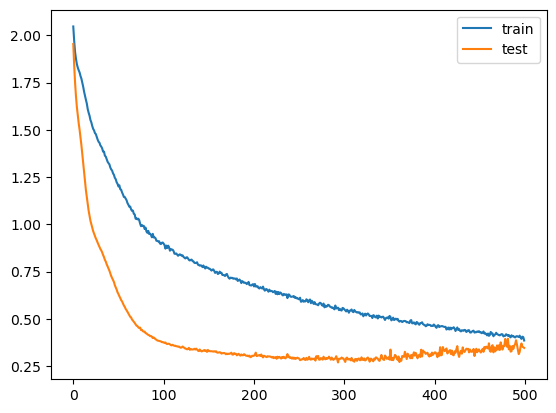

In [103]:
def lstm_model(X_train, y_train, epochs, batch_size, optimizer):
    model = keras.Sequential()
    model.add(
        keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=32,
            input_shape=[X_train.shape[1], X_train.shape[2]]
        )
        )
    )
    model.add(keras.layers.Dropout(rate=0.5))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dropout(rate=0.3))
    model.add(keras.layers.Dense(units=40, activation='relu'))
    model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['acc']
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        shuffle=True
    )
    
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend();

    return model

model = lstm_model(X_train, y_train, epochs=500, batch_size=256, optimizer='sgd')
model.evaluate(X_test, y_test)

In [526]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

92/92 [==============================] - 1s 2ms/step


In [71]:
def relativeCorrect(array):
    return array/sum(array)

def confusion_matrix_relative(y_test, y_pred):

    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    cm_relative = np.apply_along_axis(relativeCorrect, 1, cm)
    heatmap = go.Heatmap(z=cm_relative, x=enc.categories_[0], y=enc.categories_[0],
                         colorscale='Blues')


    # create the layout
    layout = go.Layout(title='Confusion Matrix with relative values for each row / actual classes')

    # create the figure
    fig = go.Figure(data=[heatmap], layout=layout)

    fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
    fig.update_yaxes(title_text="Actual")
    fig.update_xaxes(title_text="Predicted")

    fig.layout.height = 900
    fig.layout.width = 900
    # show the figure
    fig.show()

confusion_matrix_relative(y_test, y_pred)

In [506]:
cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
cm[::-1]

text=cm[::-1], texttemplate="%{text}", textfont={"size": 10}

SyntaxError: cannot assign to literal (3849225211.py, line 4)

In [ ]:
model.evaluate(X_test, y_test)

135/135 [==============================] - 3s 19ms/step - loss: 0.3774 - acc: 0.9257


[0.3774121403694153, 0.9256505370140076]

In [ ]:
y_pred = model.predict(X_test)

135/135 [==============================] - 3s 16ms/step


In [ ]:

cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
heatmap = go.Heatmap(z=cm, x=enc.categories_[0], y=enc.categories_[0], colorscale='Blues') # FEHLER IRGENDWO

# create the layout
layout = go.Layout(title='Confusion Matrix')

# create the figure
fig = go.Figure(data=[heatmap], layout=layout)

fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
fig.update_yaxes(title_text="Actual")
fig.update_xaxes(title_text="Predicted")

fig.layout.height = 900
fig.layout.width = 900
# show the figure
fig.show()

In [ ]:
def relativeCorrect(array):
    return array/sum(array)

def confusion_matrix_relative(y_test, y_pred):

    cm = confusion_matrix(enc.inverse_transform(y_test), enc.inverse_transform(y_pred))
    

    cm_relative = np.apply_along_axis(relativeCorrect, 1, cm)
    heatmap = go.Heatmap(z=cm_relative, x=enc.categories_[0], y=enc.categories_[0], colorscale='Blues') # FEHLER IRGENDWO


    # create the layout
    layout = go.Layout(title='Confusion Matrix with relative values for each row / actual classes')

    # create the figure
    fig = go.Figure(data=[heatmap], layout=layout)

    fig.update_layout(yaxis = dict(categoryorder = 'category descending'))
    fig.update_yaxes(title_text="Actual")
    fig.update_xaxes(title_text="Predicted")

    fig.layout.height = 900
    fig.layout.width = 900
    # show the figure
    fig.show()

In [ ]:
cm[0]/sum(cm[0])

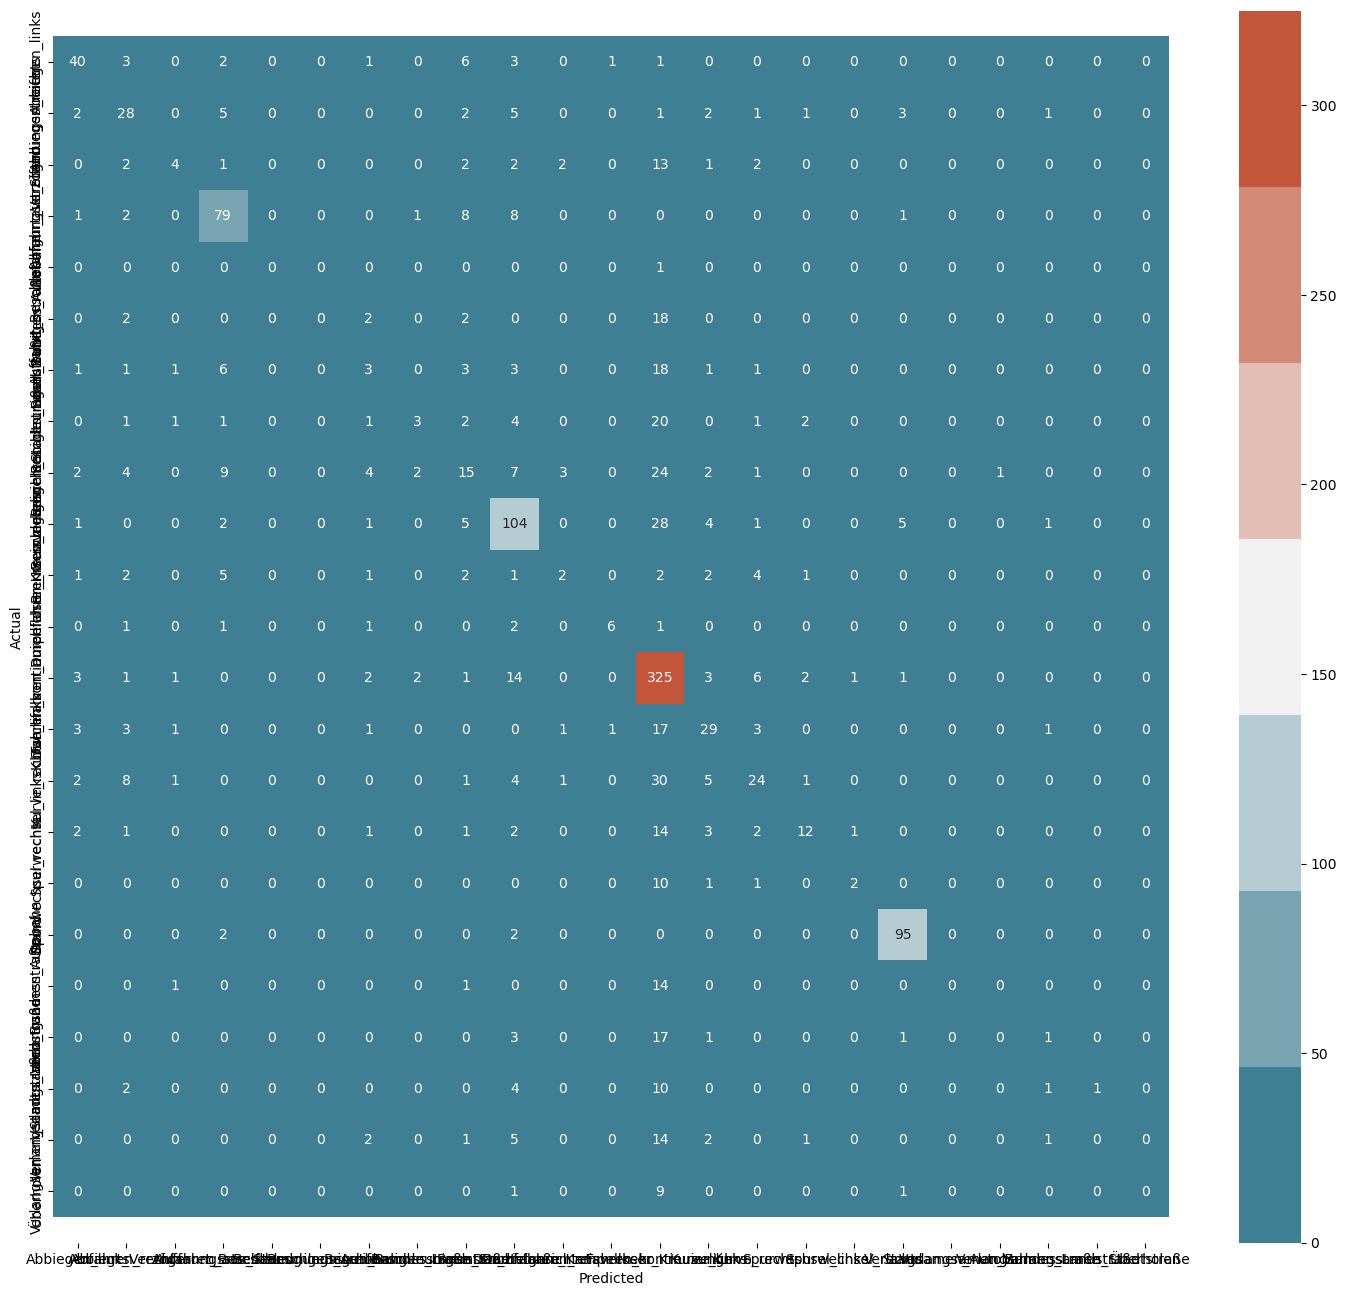

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

In [ ]:
from sklearn.preprocessing import RobustScaler


scale_columns = ['accX', 'accY', 'accZ']

scaler = RobustScaler()

scaler = scaler.fit(df_p1[scale_columns])

df_p1.loc[:, scale_columns] = scaler.transform(
  df_p1[scale_columns].to_numpy()
)

/opt/anaconda3/envs/p3-8-tensorflow04-telematic/lib/python3.8/site-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RobustScaler was fitted with feature names

/var/folders/_1/6fqc4jrn1n78r_dr5zwl5ctc0000gn/T/ipykernel_968/4214816868.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_p1.describe().round()

,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,section
count,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0,6716.0
mean,-0.0,0.0,0.0,0.0,-0.0,0.0,52.0,10.0,101.0,7.0,13.0,3.0
std,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,5.0,9.0,2.0
min,-23.0,-9.0,-12.0,-0.0,-1.0,-0.0,52.0,10.0,87.0,4.0,0.0,1.0
25%,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,52.0,10.0,96.0,4.0,5.0,1.0
50%,0.0,0.0,-0.0,0.0,-0.0,0.0,52.0,10.0,98.0,5.0,12.0,2.0
75%,1.0,1.0,1.0,0.0,0.0,0.0,52.0,10.0,105.0,8.0,19.0,4.0
max,15.0,11.0,18.0,0.0,1.0,0.0,52.0,10.0,123.0,96.0,40.0,6.0


In [ ]:
fig = px.bar(x=df_p1.maneuverType.value_counts().index, y=df_p1.maneuverType.value_counts().values,
            title='Amount of entries per maneuver type')

fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount of entries')
fig.show()

In [ ]:
df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Autobahn') & (df['maneuverElement']=='Verlangsamen'),
        'maneuverType'] = 'Verlangsamen_Autobahn'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Autobahn') & (df['maneuverElement']=='Beschleunigen'),
        'maneuverType'] = 'Beschleunigen_Autobahn'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Landstraße') & (df['maneuverElement']=='Verlangsamen'),
        'maneuverType'] = 'Verlangsamen_Landstraße'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Landstraße') & (df['maneuverElement']=='Beschleunigen'),
        'maneuverType'] = 'Beschleunigen_Landstraße'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Stadtstraße') & (df['maneuverElement']=='Verlangsamen'),
        'maneuverType'] = 'Verlangsamen_Stadtstraße'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Stadtstraße') & (df['maneuverElement']=='Beschleunigen'),
        'maneuverType'] = 'Beschleunigen_Stadtstraße'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Bundesstraße') & (df['maneuverElement']=='Verlangsamen'),
        'maneuverType'] = 'Verlangsamen_Bundesstraße'

df.loc[(df['maneuverType']=='Fahren_kontinuierlich') & (df['roadType']=='Bundesstraße') & (df['maneuverElement']=='Beschleunigen'),
        'maneuverType'] = 'Beschleunigen_Bundesstraße'